In [1]:
import cv2
import numpy as np
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from random import randint
%matplotlib inline

In [2]:
def read_image(path):
    img = np.asarray(Image.open(path))
    return img

def write_image_to_file(img, path):
    cv2.imwrite(path, img)
    
def draw_image(image):
    image = np.squeeze(image)
    plt.figure(figsize=(7, 7))
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

def resize_image(img, resize_shape):
    res = cv2.resize(img, dsize=resize_shape, interpolation=cv2.INTER_CUBIC)
    return res    

In [3]:
def get_bounding_boxes(image):
    bboxes = []
    ret, thresh = cv2.threshold(img, 120, 255, 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    dilate = cv2.dilate(thresh, kernel, iterations=3)
#     draw_image(dilate)
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if (area > 400.0):
            x, y, w, h = cv2.boundingRect(cnt)
            crop = thresh[y:y+h, x:x+w]
            
            white_count = crop[crop > 1].shape[0]
            black_count = crop[crop < 1].shape[0]
#             print(while_count/black_count)
            
            if (white_count/black_count > 0.08):
                bboxes.append(cv2.boundingRect(cnt))
    return bboxes
    

In [4]:
def draw_bboxes(gray_img, bboxes):
    img = cv2.cvtColor(gray_img,cv2.COLOR_GRAY2RGB)
    for b in bboxes:
        x, y, w, h = b
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    draw_image(img)

In [5]:
def crop_selection(img, bbox):
    x, y, w, h = bbox
    crop = img[y:y+h, x:x+w]
    return crop

In [6]:
base_path = "/Users/chamathabeysinghe/Projects/monash/VAE_v2/data/intermediate/single_ant_bw"
img_paths = [os.path.join(base_path, x) for x in os.listdir(base_path) if not x.startswith('.')]


In [7]:
ants = []
for i_path in img_paths:
    img = read_image(i_path)
    bboxes = get_bounding_boxes(img)
    crop = crop_selection(img, bboxes[0])
    ants.append(crop)
#     draw_bboxes(img, bboxes)

In [ ]:
with open('ants.pkl', 'wb') as f:
    pickle.dump(ants, f)

## Create synthetic antdataset

In [ ]:
with open('ants.pkl', 'rb') as f:
    ants = pickle.load(f)

In [ ]:
def draw_ant(back):
    ant_index = randint(0, len(ants)-1)
    ant_img = ants[ant_index]
    bak_h, bak_w = back.shape
    ant_h, ant_w = ant_img.shape
    
    start_x = randint(0, bak_h - ant_h)
    start_y = randint(0, bak_w - ant_w)
    
    back[start_x:start_x+ant_h, start_y: start_y+ ant_w] += ant_img
    

In [ ]:
def draw_images (original_size, resize_size, path, file_index):
    background = np.zeros((original_size, original_size))
#     if file_index%3 > 0:
#         draw_ant(background)
        
    for i in range(file_index%4):
        draw_ant(background)
    background = resize_image(background, (resize_size, resize_size))
    write_image_to_file(background, os.path.join(path, '{:05d}.png'.format(file_index)))
    return background

In [ ]:
original_size = 300
resize_size = 75
base_path = '/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/data/ANTS-SYNTHETIC/test-original: {}-resize: {}-3ants'.format(original_size, resize_size)
os.makedirs(base_path, exist_ok=True)

In [ ]:
images = []
for i in range(1000):
    print(i)
    img = draw_images(original_size, resize_size, base_path, i)
    images.append(img)
images = np.asarray(images)
# np.random.shuffle(images)
np.save(base_path, images)

In [ ]:
draw_image(images[6])

## Advanced dataset

In [22]:
def draw_close_ants(back, count):
    
    ant_imgs = []
    
    for _ in range(count):
        ant_index = randint(0, len(ants)-1)
        ant_img = ants[ant_index]
        ant_imgs.append(ant_img)
        
        
    bak_h, bak_w, _ = back.shape
    
    ant_img = ant_imgs[0]
    ant_h, ant_w = ant_img.shape
    start_x = randint(0, bak_h - ant_h)
    start_y = randint(0, bak_w - ant_w)
    shape = back.shape
    print(shape)
    back = Image.fromarray(back, mode="RGBA")
    plt.imshow(back)
    for i in range(1, count+1):
        new_back = np.zeros(shape)
        new_back[start_x:start_x+ant_h, start_y: start_y+ ant_w] += ant_img
        new_back = Image.fromarray(new_back)
        new_back = new_back.convert("RGBA")
    
        
        back = Image.alpha_composite(back, new_back)
        plt.imshow(back)
#         back[start_x:start_x+ant_h, start_y: start_y+ ant_w] += ant_img
        if (i >= len(ant_imgs)):
            break
        ant_img = ant_imgs[i]
        ant_h, ant_w = ant_img.shape
        start_x = min(max(0, start_x + randint(-50, 50)), bak_h - ant_h)
        start_y = min(max(0, start_y + randint(-50, 50)), bak_w - ant_w)
    back = back.convert("RGB")   
    return back

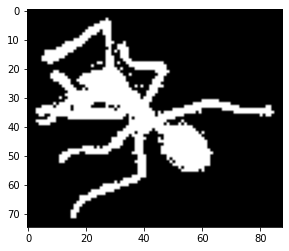

In [125]:
ant_img = ants[2]
overlay = np.full(ant_img.shape, 0)
overlay[ant_img > 1] = 255
ant_img = cv2.cvtColor(ant_img, cv2.COLOR_GRAY2RGB)

plt.imshow(overlay, cmap='gray')


In [126]:
overlay = overlay.reshape((ant_img.shape[0], ant_img.shape[1], 1))
overlay.shape

(75, 88, 1)

In [130]:
c = np.concatenate((ant_img, overlay), axis=2)
c = c.astype(np.uint8)


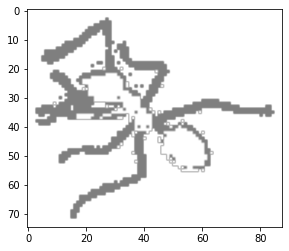

In [131]:
plt.imshow(c)

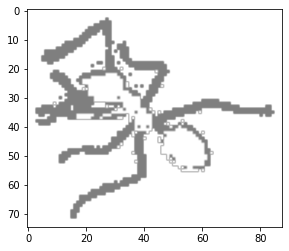

In [134]:
i = Image.fromarray(c, mode='RGBA')
plt.imshow(i)
i = i.convert("RGB")

i.save("img2.png", "PNG")

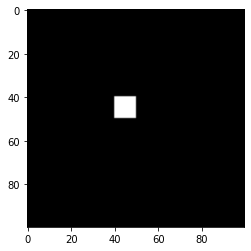

In [121]:
back = np.zeros((100, 100, 4))
obj = np.full((10, 10, 4), 255)
back[40:50, 40:50, :] = obj
back = back.astype(np.uint8)

plt.imshow(back)
img = Image.fromarray(back, mode='RGBA')
img = img.convert("RGB")
plt.imshow(img)
img.save("img2.png", "PNG")

(300, 300, 4)


ValueError: operands could not be broadcast together with shapes (110,107,4) (110,107) (110,107,4) 

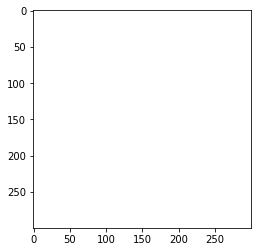

In [23]:
background = np.zeros((300, 300, 4))
background = draw_close_ants(background, 3)
background = np.asarray(background)
# plt.imshow(background)

In [ ]:
def draw_images_advanced (original_size, resize_size, path, file_index):
    background = np.zeros((original_size, original_size))
#     if file_index%3 > 0:
#         draw_ant(background)
        
    background = draw_close_ants(background, 3)
    background = np.asarray(background)
    background = resize_image(background, (resize_size, resize_size))
    write_image_to_file(background, os.path.join(path, '{:05d}.png'.format(file_index)))
    return background

In [ ]:
original_size = 300
resize_size = 75
base_path = '/Users/chamathabeysinghe/Projects/monash/VAE_v2/data/synthetic/complex_dataset/original:_{}-resize:_{}-3ants'.format(original_size, resize_size)
os.makedirs(base_path, exist_ok=True)


In [ ]:
images = []
for i in range(100):
    img = draw_images_advanced(original_size, resize_size, base_path, i)
    images.append(img)
images = np.asarray(images)
# np.random.shuffle(images)
np.save(base_path, images)

In [ ]:
plt.imshow(images[2])

In [ ]:
np.max(images[0])